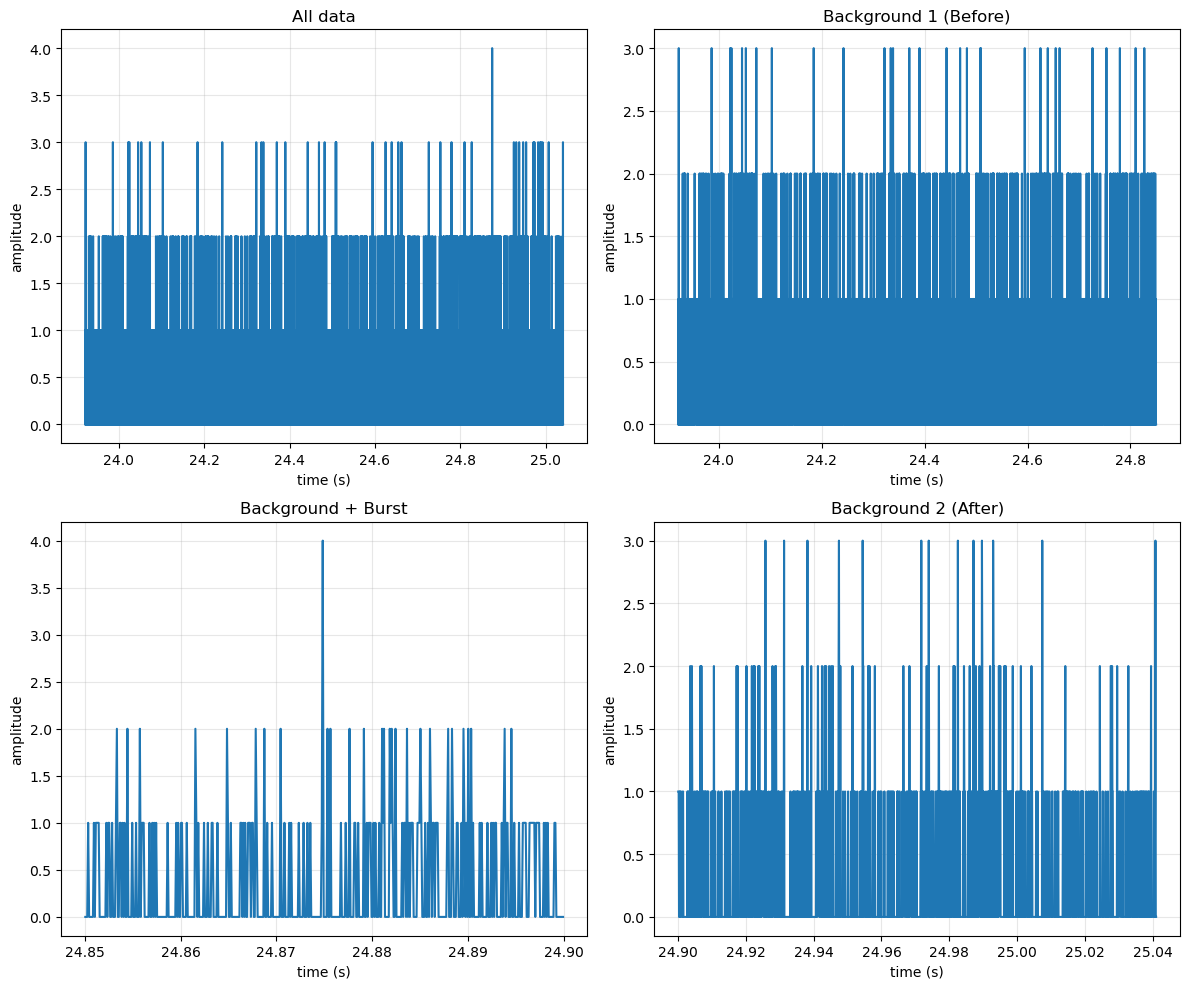

In [4]:

import numpy as np
import matplotlib.pyplot as plt

# read the light curve data
Parent_dir = '/data/nas_data/wsy/GW2025/hw1/'
filename = 'lightcurve_0.1msbin.txt'
File_all = np.loadtxt(Parent_dir + filename)
times = File_all[0 , :]
amps = File_all[1 , :]
# divide the signal into three segments
breaking_p1 = 24.85
breaking_p2 = 24.90
times1 = times[times < breaking_p1]
times2 = times[(times >= breaking_p1) & (times <= breaking_p2)]
times3 = times[times > breaking_p2]
amps1 = amps[times < breaking_p1]
amps2 = amps[(times >= breaking_p1) & (times <= breaking_p2)]
amps3 = amps[times > breaking_p2]
'''
plt.figure()
plt.plot(times1, amps1)
plt.title('Background 1 (Before)')
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.show()

plt.figure()
plt.plot(times2, amps2)
plt.title('Background + Burst')
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.show()

plt.figure()
plt.plot(times3, amps3)
plt.title('Background 2 (After)')
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.show()
'''


fig, axs = plt.subplots(2, 2, figsize=(12, 10))  

axs[0, 0].plot(times, amps)
axs[0, 0].set_title('All data', fontsize=12)
axs[0, 0].set_xlabel('time (s)', fontsize=10)
axs[0, 0].set_ylabel('amplitude', fontsize=10)
axs[0, 0].grid(alpha=0.3)

axs[0, 1].plot(times1, amps1)  
axs[0, 1].set_title('Background 1 (Before)', fontsize=12)  
axs[0, 1].set_xlabel('time (s)', fontsize=10)  
axs[0, 1].set_ylabel('amplitude', fontsize=10) 
axs[0, 1].grid(alpha=0.3)  


axs[1, 0].plot(times2, amps2)
axs[1, 0].set_title('Background + Burst', fontsize=12)
axs[1, 0].set_xlabel('time (s)', fontsize=10)
axs[1, 0].set_ylabel('amplitude', fontsize=10)
axs[1, 0].grid(alpha=0.3)

axs[1, 1].plot(times3, amps3)
axs[1, 1].set_title('Background 2 (After)', fontsize=12)
axs[1, 1].set_xlabel('time (s)', fontsize=10)
axs[1, 1].set_ylabel('amplitude', fontsize=10)
axs[1, 1].grid(alpha=0.3)



plt.tight_layout()
plt.savefig('LCs.pdf', format = 'pdf')
plt.show() 

In [5]:
# time series analysis
# DCF method is used to find characteristic time lags
def DCF_cal(arr_a, arr_b, taos, bin_width):

    if arr_a.ndim != 2 or arr_b.ndim != 2:
        raise ValueError("输入数组必须是二维数组 (形状为[N,2]和[M,2])")
    

    t_a, amp_a = arr_a[:, 0], arr_a[:, 1]
    t_b, amp_b = arr_b[:, 0], arr_b[:, 1]
    

    ma, mb = np.mean(amp_a), np.mean(amp_b)
    sa, sb = np.std(amp_a, ddof=1), np.std(amp_b, ddof=1)
    
    dt = t_a[:, np.newaxis] - t_b  # broadcast

    UDCF = ( (amp_a - ma)[:, np.newaxis] * (amp_b - mb) ) / (sa * sb)
    
    dt_flat = dt.ravel()
    UDCF_flat = UDCF.ravel()
    
    n_bins = len(taos) - 1
    DCF = np.zeros(n_bins)
    DCF_err = np.zeros(n_bins)
    M_counts = np.zeros(n_bins, dtype=int)  
    t_mid = 0.5 * (taos[1:] + taos[:-1]) 
    
    for k in range(n_bins):
        tao_min = taos[k]
        tao_max = tao_min + bin_width
        zero_lag_bin = 0.01 * bin_width
        
        if abs(tao_min) < 1e-9:  # 0 time lag
            tao_max = tao_min + zero_lag_bin # use a smaller time width
        else:
            tao_max = tao_min + bin_width 
            
        mask = (dt_flat >= tao_min) & (dt_flat < tao_max)
        M_counts[k] = np.sum(mask)  

        
        UDCF_bin = UDCF_flat[mask]
        DCF[k] = np.sum(UDCF_bin) / M_counts[k]
        DCF_err[k] = np.sqrt(np.sum((UDCF_bin-DCF[k])**2))/(M_counts[k]-1)
        
    return t_mid, DCF, DCF_err

/tmp/ipykernel_390254/3709323408.py:44: RuntimeWarning: invalid value encountered in scalar divide
  DCF[k] = np.sum(UDCF_bin) / M_counts[k]


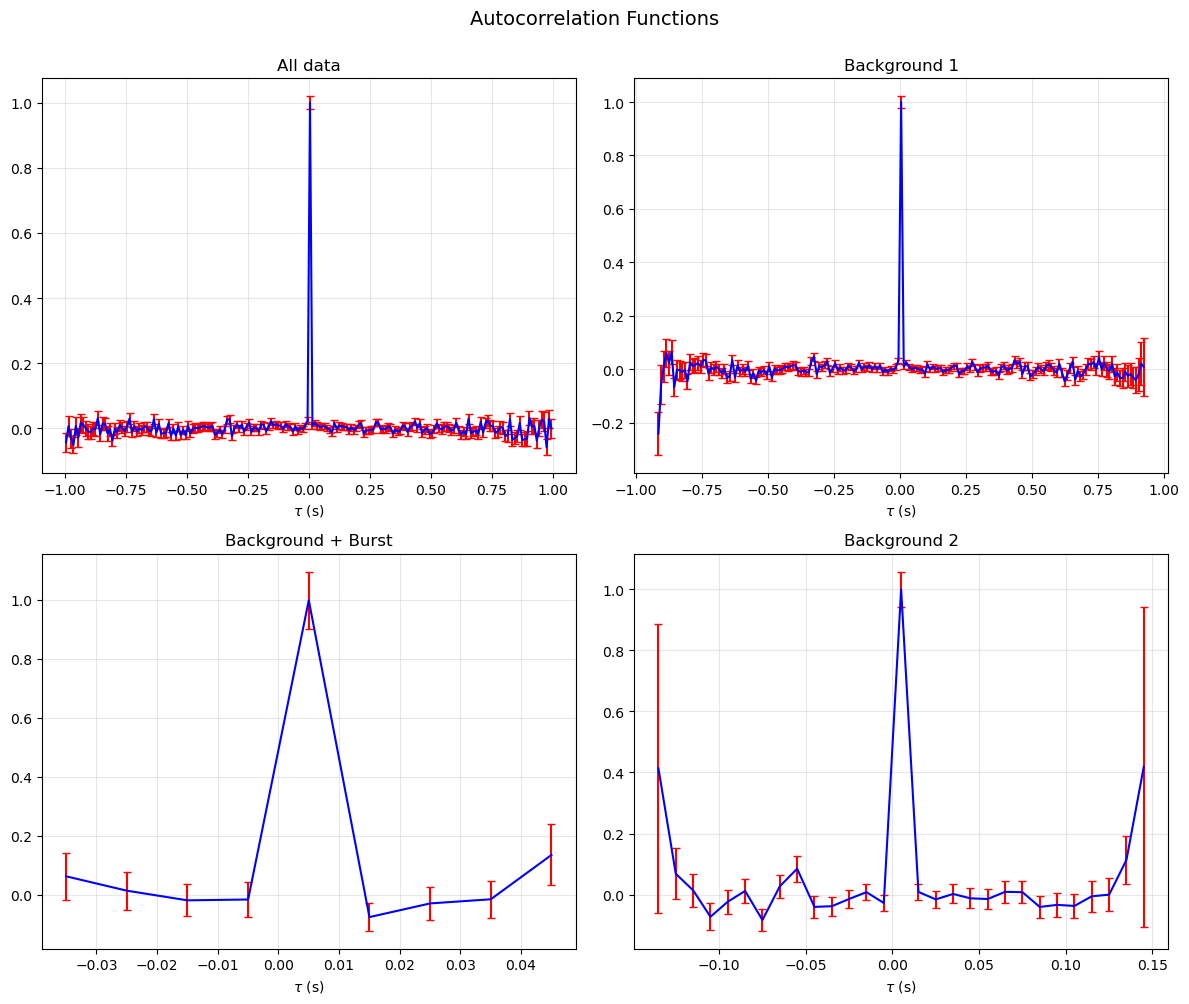

In [6]:
taos = np.linspace(-1, 1, 201)
#print(taos)
bin = 1e-4
arr1 = np.column_stack((times1, amps1)) # background 1
arr2 = np.column_stack((times2, amps2)) # background + burst 
arr3 = np.column_stack((times3, amps3)) # background 2
arr_all = np.column_stack((times, amps))
t_mid1, DCF1, DCF_err1 = DCF_cal(arr_all,arr_all,taos,bin)
t_mid2, DCF2, DCF_err2 = DCF_cal(arr1,arr1,taos,bin)
t_mid3, DCF3, DCF_err3 = DCF_cal(arr2,arr2,taos,bin)
t_mid4, DCF4, DCF_err4 = DCF_cal(arr3,arr3,taos,bin)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))  

fig.suptitle('Autocorrelation Functions', fontsize=14, y=1)

axs[0, 0].errorbar(t_mid1, DCF1, yerr=DCF_err1, ecolor='r', fmt='b-', capsize=3) 
axs[0, 0].set_title('All data', fontsize=12) 
axs[0, 0].set_xlabel(r'$\tau$ (s)', fontsize=10)  
axs[0, 0].grid(alpha=0.3)


axs[0, 1].errorbar(t_mid2, DCF2, yerr=DCF_err2, ecolor='r', fmt='b-', capsize=3)
axs[0, 1].set_title('Background 1', fontsize=12)
axs[0, 1].set_xlabel(r'$\tau$ (s)', fontsize=10)
axs[0, 1].grid(alpha=0.3)


axs[1, 0].errorbar(t_mid3, DCF3, yerr=DCF_err3, ecolor='r', fmt='b-', capsize=3)
axs[1, 0].set_title('Background + Burst', fontsize=12)
axs[1, 0].set_xlabel(r'$\tau$ (s)', fontsize=10)
axs[1, 0].grid(alpha=0.3)

axs[1, 1].errorbar(t_mid4, DCF4, yerr=DCF_err4, ecolor='r', fmt='b-', capsize=3)
axs[1, 1].set_title('Background 2', fontsize=12)
axs[1, 1].set_xlabel(r'$\tau$ (s)', fontsize=10)
axs[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('ACFs.pdf', format = 'pdf')
plt.show()

/tmp/ipykernel_390254/3709323408.py:44: RuntimeWarning: invalid value encountered in scalar divide
  DCF[k] = np.sum(UDCF_bin) / M_counts[k]


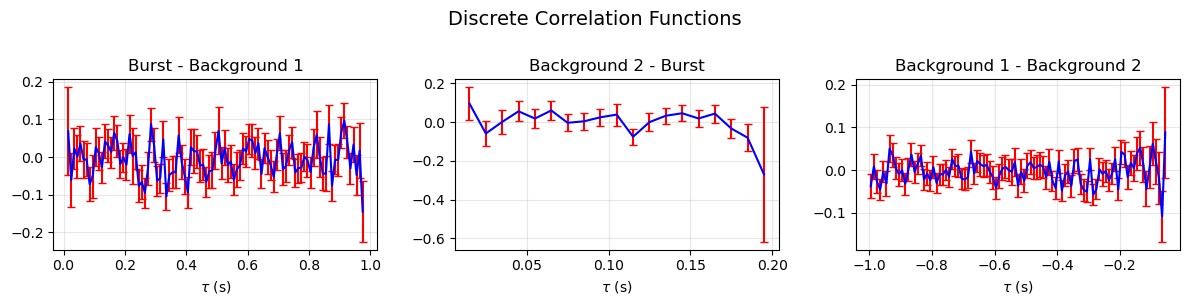

In [7]:
t_mid1, DCF1, DCF_err1 = DCF_cal(arr2,arr1,taos, bin)
t_mid2, DCF2, DCF_err2 = DCF_cal(arr3,arr2,taos,bin)
t_mid3, DCF3, DCF_err3 = DCF_cal(arr1,arr3,taos,bin)
fig, axs = plt.subplots(1, 3, figsize=(12,3))  

fig.suptitle('Discrete Correlation Functions', fontsize=14, y=1)

axs[0].errorbar(t_mid1, DCF1, yerr=DCF_err1, ecolor='r', fmt='b-', capsize=3) 
axs[0].set_title('Burst - Background 1', fontsize=12) 
axs[0].set_xlabel(r'$\tau$ (s)', fontsize=10)  
axs[0].grid(alpha=0.3)


axs[1].errorbar(t_mid2, DCF2, yerr=DCF_err2, ecolor='r', fmt='b-', capsize=3)
axs[1].set_title('Background 2 - Burst', fontsize=12)
axs[1].set_xlabel(r'$\tau$ (s)', fontsize=10)
axs[1].grid(alpha=0.3)


axs[2].errorbar(t_mid3, DCF3, yerr=DCF_err3, ecolor='r', fmt='b-', capsize=3)
axs[2].set_title('Background 1 - Background 2', fontsize=12)
axs[2].set_xlabel(r'$\tau$ (s)', fontsize=10)
axs[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('DCFs.pdf', format = 'pdf')
plt.show()

<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:37: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_390254/3107805420.py:37: SyntaxWarning: invalid escape sequence '\s'
  '''


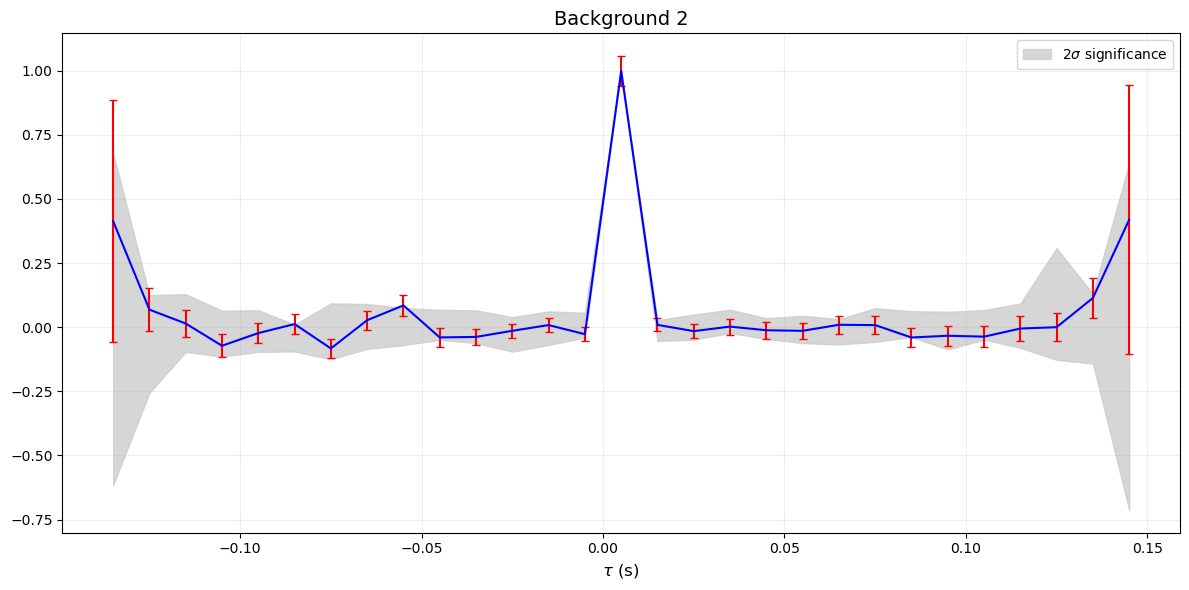

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os

Parent_dir = '/data/nas_data/wsy/GW2025/hw1/'
result_file = os.path.join(Parent_dir, 'Signi', 'arr3_autocorr_results.txt')  # 1000个自相关结果
taos = np.linspace(-1, 1, 201)  
taus_mid = 0.5 * (taos[1:] + taos[:-1]) 

# (2σ=95.4%，3σ=99.7%）
quantiles_2sigma = [2.3, 97.7]
quantiles_3sigma = [0.15, 99.85]

autocorr_results = np.loadtxt(result_file)

n_taus = autocorr_results.shape[1]

ci2_low = np.full(n_taus, np.nan)
ci2_high = np.full(n_taus, np.nan)
ci3_low = np.full(n_taus, np.nan)
ci3_high = np.full(n_taus, np.nan)

for tau_idx in range(n_taus):
    samples = autocorr_results[:, tau_idx]
    valid_samples = samples[~np.isnan(samples)]
    
    if len(valid_samples) > 10:
        ci2_low[tau_idx], ci2_high[tau_idx] = np.percentile(valid_samples, quantiles_2sigma)
        ci3_low[tau_idx], ci3_high[tau_idx] = np.percentile(valid_samples, quantiles_3sigma)


plt.figure(figsize=(12, 6))

plt.errorbar(t_mid4, DCF4, yerr=DCF_err4, ecolor='r', fmt='b-', capsize=3)
plt.grid(alpha=0.3)

'''
plt.fill_between(
    taus_mid, 
    ci3_low, 
    ci3_high, 
    color='#EEEEEE', 
    alpha=0.8, 
    label=r'3$\sigma$ significance'
)'''


plt.fill_between(
    taus_mid, 
    ci2_low, 
    ci2_high, 
    color='#CCCCCC', 
    alpha=0.8, 
    label=r'2$\sigma$ significance'
)


plt.xlabel(r'$\tau$ (s)', fontsize=12)
plt.title('Background 2', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.2)
plt.tight_layout() 
plt.savefig('ACF1_sig.pdf', format = 'pdf')
plt.show()

<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:37: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_390254/2492293016.py:37: SyntaxWarning: invalid escape sequence '\s'
  '''


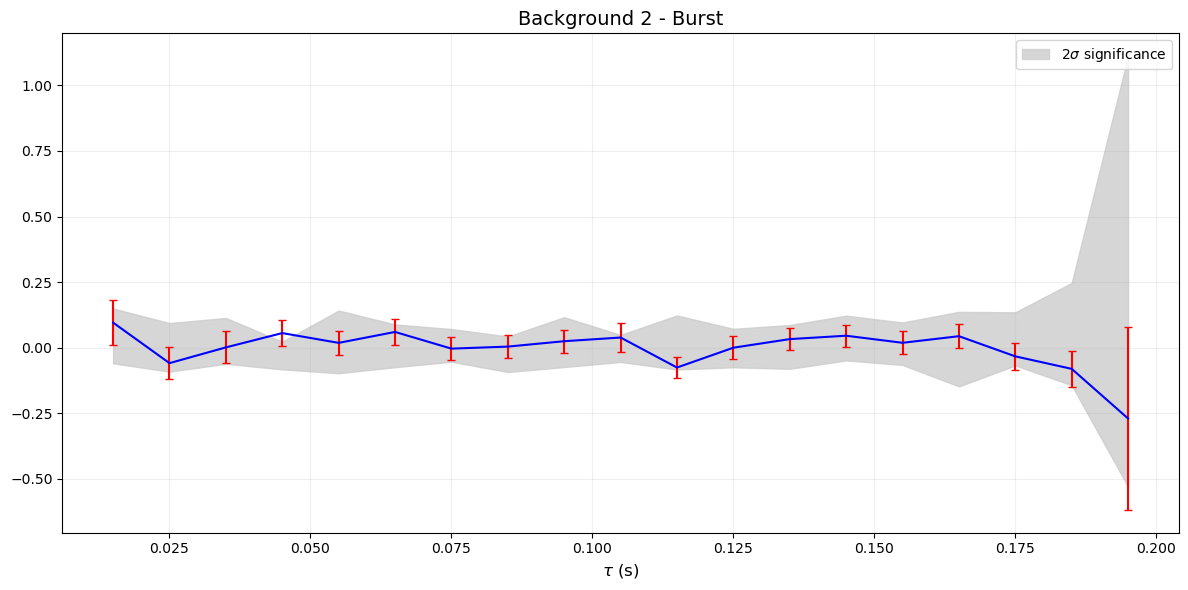

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os

Parent_dir = '/data/nas_data/wsy/GW2025/hw1/'
result_file = os.path.join(Parent_dir, 'Signi', 'arr3arr2_dcf_results.txt')  # 1000个自相关结果
taos = np.linspace(-1, 1, 201)  
taus_mid = 0.5 * (taos[1:] + taos[:-1]) 

# (2σ=95.4%，3σ=99.7%）
quantiles_2sigma = [2.3, 97.7]
quantiles_3sigma = [0.15, 99.85]

autocorr_results = np.loadtxt(result_file)

n_taus = autocorr_results.shape[1]

ci2_low = np.full(n_taus, np.nan)
ci2_high = np.full(n_taus, np.nan)
ci3_low = np.full(n_taus, np.nan)
ci3_high = np.full(n_taus, np.nan)

for tau_idx in range(n_taus):
    samples = autocorr_results[:, tau_idx]
    valid_samples = samples[~np.isnan(samples)]
    
    if len(valid_samples) > 10:
        ci2_low[tau_idx], ci2_high[tau_idx] = np.percentile(valid_samples, quantiles_2sigma)
        ci3_low[tau_idx], ci3_high[tau_idx] = np.percentile(valid_samples, quantiles_3sigma)


plt.figure(figsize=(12, 6))

plt.errorbar(t_mid2, DCF2, yerr=DCF_err2, ecolor='r', fmt='b-', capsize=3)
axs[1].grid(alpha=0.3)

'''
plt.fill_between(
    taus_mid, 
    ci3_low, 
    ci3_high, 
    color='#EEEEEE', 
    alpha=0.8, 
    label=r'3$\sigma$ significance'
)'''


plt.fill_between(
    taus_mid, 
    ci2_low, 
    ci2_high, 
    color='#CCCCCC', 
    alpha=0.8, 
    label=r'2$\sigma$ significance'
)


plt.xlabel(r'$\tau$ (s)', fontsize=12)
plt.title('Background 2 - Burst', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.2)
plt.tight_layout() 
plt.savefig('DCF1_sig.pdf', format = 'pdf')
plt.show()